# Анализ лояльности пользователей Яндекс Афиши
- Автор: *Шлыков Алексей*
- Дата: *11.02.2026*

### Цели и задачи проекта
**Цель:**    
Провести исследовательский анализ данных сервиса Яндекс Афиша с целью составления профиля пользователя, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. Предоставить заказчику информацию, какие пользователи возвращаются на платформу и с высокой вероятностью будут совершать повторные заказы, предоставить рекомендации на основе полученных инсайтов.  

**Задачи:**    
1. Загрузить данные и ознакомиться с данными
2. Провести предобработку данных
3. Построить профиль пользователя
4. Провести исследовательский анализ
5. Сформировать итоговые выводы и рекомендации

### Описание данных
- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

### Содержимое проекта
1. Загрузка данных и знакомство с ними
    - 1.1. Загрузка данных и их предобработка
    - 1.2. Знакомство с данными
2. Предобработка данных
    - 2.1. Приведение выручки к единой валюте
    - 2.2. Предобработка данных
3. Создание профиля пользователя
    - 3.1. Построение профиля пользователя по первому заказу
    - 3.2. Оценка репрезентативности данных
4. Исследовательский анализ данных
    - 4.1. Исследование признаков первого заказа
        - 4.1.1. Распределение пользователей по признакам
        - 4.1.2. Анализ возвращаемости по сегментам
        - 4.1.3. Проверка продуктовых гипотез
    - 4.2. Анализ выручки и состава заказа
        - 4.2.1. Связь выручки с повторными заказами
        - 4.2.2. Сравнение выручки для разных групп лояльности
        - 4.2.3. Влияние количества билетов на возвращаемость
    - 4.3. Исследование временных характеристик
        - 4.3.1. Влияние дня недели первого заказа
        - 4.3.2. Анализ интервалов между заказами
    - 4.4. Корреляционный анализ
        - 4.4.1. Расчет коэффициента корреляции Phi_k
5. Общий вывод и рекомендации
    - 5.1. Итоги подготовки данных
    - 5.2. Сводка ключевых результатов
    - 5.3. Рекомендации для Яндекс Афиши
    - 5.4. Ограничения и дальнейшие исследования

## 1. Загрузка данных и знакомство с ними

### 1.1. Загрузка данных и их предобработка

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
from phik import phik_matrix

# Загружаем библиотеку для подключения к базе данных
from sqlalchemy import create_engine

# Импорт библиотеки для работы с окружением
import os

# Импорт load_dotenv
from dotenv import load_dotenv

In [2]:
# Создадаем переменную, содержащую конфигурацию для подключения к базе данных
load_dotenv()

db_config = {
    'user': os.getenv('DB_USER'),
    'pwd': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT'),
    'db': os.getenv('DB_NAME')
}

In [3]:
# Создаем строку для подключения
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
# Создаем соединение
engine = create_engine(connection_string)

In [5]:
# Записываем в переменную SQL запрос
query = '''
SELECT 
	user_id,
	device_type_canonical,
	order_id,
	created_dt_msk AS order_dt,
	created_ts_msk AS order_ts,
	currency_code,
	tickets_count,
	revenue,
	date(created_dt_msk) - date(LAG(created_dt_msk) OVER (PARTITION BY user_id ORDER BY created_dt_msk)) AS days_since_prev,
	event_id,
	event_name_code AS event_name,
	event_type_main,
	service_name,
	region_name,
	city_name
FROM
	afisha.purchases
LEFT JOIN afisha.events
		USING (event_id)
LEFT JOIN afisha.city
		USING (city_id)
LEFT JOIN afisha.regions
		USING (region_id)
WHERE
	(device_type_canonical = 'mobile'
		OR device_type_canonical = 'desktop')
	AND event_type_main != 'фильм'
ORDER BY
user_id;
'''

In [6]:
# Проводим выгрузку данных
df = pd.read_sql_query(query, con=engine)

Данные загружены.  
Далее мы изучим общую информацию о данных, оченим корректность выгрузки и объем полученных данных.

### 1.2. Знакомство с данными

In [7]:
# Выводим первые строки датасета
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,tickets_count,revenue,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,4,1521.94,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,2,289.45,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,4,1258.57,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,2,8.49,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,3,1390.41,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [8]:
# Выводим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   tickets_count          290611 non-null  int64         
 7   revenue                290611 non-null  float64       
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [9]:
# Запишем в переменную количество строк для дальнейших расчетов
initial_rows = df.shape[0]

**Промежуточные выводы:**
- Загружено 290 611 строк из 292 034 (отфильтровано 1 423 записи по типам устройств и мероприятий)
- Подтверждено: 15 столбцов с корректными названиями и типами данных
- Пропуски обнаружены только в days_since_prev (обусловлены первыми покупками пользователей)
- Данные выгружены корректно, целостность сохранена
- Столбцы с числовыми данными могут быть оптимизированы для экономии памяти
- Выручка представлена в двух валютах: российский рубль (RUB) и казахстанский тенге (KZT)
- Требуется конвертация к единой валюте для дальнейшего анализа

---

# 2. Предобработка данных


---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


### 2.1. Приведение выручки к единой валюте

In [10]:
# Загрузим датасет с информацией о курсе тенге к рублю за 2024 год
df_kzt = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [11]:
# Приводим столбец к типу даты и времени
df_kzt['order_dt'] = pd.to_datetime(df_kzt['data'])

# Объединяем датафреймы
df = df.merge(df_kzt, on='order_dt', how='left')

# Создаем отдельную колонку, в которую сохраним конвертированные значения
df['revenue_rub'] = df['revenue'].copy()

# Находим все записи где валютой является тенге
mask = df['currency_code'] == 'kzt'

# Осуществляем конвертацию
df.loc[mask, 'revenue_rub'] = (df.loc[mask, 'revenue_rub'] * df['curs'] / 100).round(2)

# Оставляем исходные столбцы датафрейма
df = df[['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts',
       'currency_code', 'tickets_count', 'revenue', 'days_since_prev',
       'event_id', 'event_name', 'event_type_main', 'service_name',
       'region_name', 'city_name', 'revenue_rub']]

Выручка приведена к единой валюте, создан новый столбец `revenue_rub`.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [12]:
# Смотрим число пропусков в датафрейме
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
tickets_count                0
revenue                      0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

Пропуски (21 933) присутствуют только в столбце `days_since_prev`, что соответсвует изначальным условиям к витрине данных.

In [13]:
# Оптимизируем столбцы с числовыми типами данных
for column in ['order_id', 'tickets_count', 'event_id']:
    df[column] = pd.to_numeric(df[column], downcast='integer')
for column in ['revenue', 'days_since_prev', 'revenue_rub']:
    df[column] = pd.to_numeric(df[column], downcast='float')
for column in ['order_dt', 'order_ts']:
    df[column] = pd.to_datetime(df[column])

In [14]:
# Проверим номинальные значения в столбцах с категориальными признаками
for column in ['device_type_canonical', 'currency_code', 'event_type_main']:
    print(df[column].value_counts())
    print('-' * 10)

mobile     232490
desktop     58121
Name: device_type_canonical, dtype: int64
----------
rub    285542
kzt      5069
Name: currency_code, dtype: int64
----------
концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: event_type_main, dtype: int64
----------


Данные представлены корректно и не нуждаются в дополнительной нормализации.

In [15]:
# Приведем столбцы к категориальному типу данных
cat_columns = ['device_type_canonical', 'currency_code', 'device_type_canonical', 'event_type_main']
for column in cat_columns:
    df[column] = df[column].astype('category')

In [16]:
# Проверяем результат оптимизации
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  category      
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  category      
 6   tickets_count          290611 non-null  int8          
 7   revenue                290611 non-null  float32       
 8   days_since_prev        268678 non-null  float32       
 9   event_id               290611 non-null  int32         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  category      
 12  service_name           290611 non-null  obje

Оптимизация произведена корректно.

In [17]:
device_count = df.groupby('device_type_canonical')['order_id'].count().sort_values(ascending=False)
device_count

device_type_canonical
mobile     232490
desktop     58121
Name: order_id, dtype: int64

In [18]:
# Выведем описательные статистики данных о выручке
df['revenue_rub'].describe()

count    290611.000000
mean        555.568237
std         875.455505
min         -90.760002
25%         113.970001
50%         351.140015
75%         802.049988
max       81174.539062
Name: revenue_rub, dtype: float64

In [19]:
# Подсчитаем общее количество строк с нулевыми и отрицательными значениями
df.loc[df['revenue_rub'] <= 0, 'revenue_rub'].count()

5907

Можно заметить, что в данных о выручке встречаются отрицательные и нулевые значения (5907 строк), что может говорить о наличии записей с транзакциями возврата и отмены заказов . Это небольшой процент от всех данных, оставим эти записи, их удаление может исказить финансовую картину.    
Максимальное значение в 81тыс. рублей при среднем значении в 555руб. указывает на наличие сильных выбросов в данных, которые следует рассмотреть подробнее. 

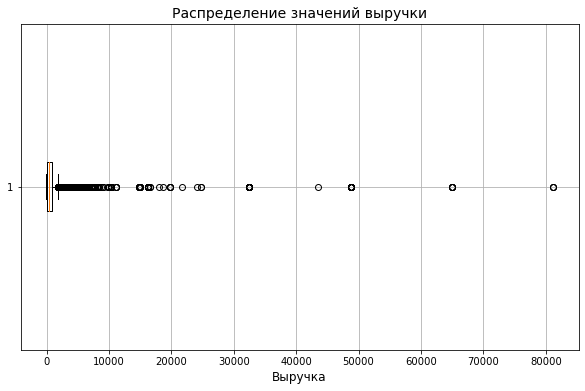

In [20]:
# Визуализируем распределение выручки
plt.figure(figsize=(10,6))
plt.boxplot(df['revenue_rub'], vert=False)
plt.title('Распределение значений выручки', fontsize=14)
plt.grid(True)
plt.xlabel('Выручка', fontsize=12)
plt.show()

Видим наличие небольшое количество сильных выбросов в правой части диаграммы. Они могут исказить усредненные  показатели. Отфильтруем данные по 99-му процентилю, согласно прямой рекомендации.

In [21]:
# Проводим фильтрацию
revenue_filtered = df['revenue_rub'].quantile(0.99)
df = df.loc[df['revenue_rub'] <= revenue_filtered]

In [22]:
# Выведем описательные статистики отфильтрованных данных
df['revenue_rub'].describe()

count    287786.000000
mean        518.028076
std         511.974091
min         -90.760002
25%         111.849998
50%         343.849991
75%         788.659973
max        2628.419922
Name: revenue_rub, dtype: float64

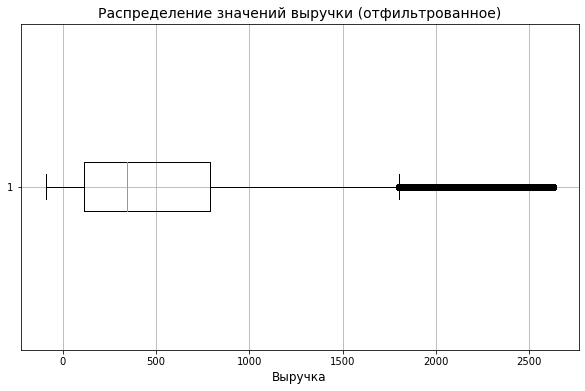

In [23]:
# Визуализируем отфильтрованные данные
plt.figure(figsize=(10,6))
plt.boxplot(df['revenue_rub'], vert=False)
plt.title('Распределение значений выручки (отфильтрованное)', fontsize=14)
plt.grid(True)
plt.xlabel('Выручка', fontsize=12)
plt.show()

Теперь распределение выручки более репрезентативно. Стандартное отклонение уменьшилось с 1227 до 567, при том, что медиана осталась практически без изменений: 356 и 347 после фильтрации.

In [24]:
# Посмотрим статистические показателя по числу билетов в заказах
df['tickets_count'].describe()

count    287786.000000
mean          2.740495
std           1.163073
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          57.000000
Name: tickets_count, dtype: float64

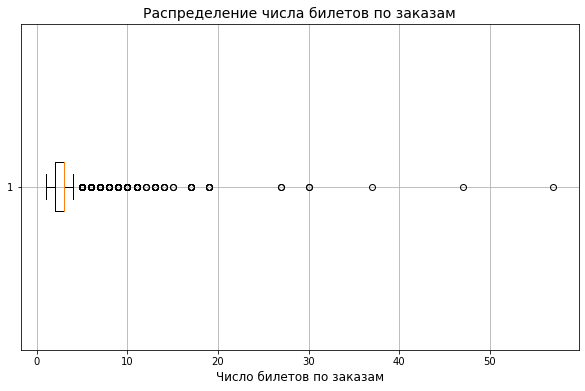

In [25]:
# Наглядно посмотрим на распределение числа билетов в заказах
plt.figure(figsize=(10,6))
plt.boxplot(df['tickets_count'], vert=False)
plt.title('Распределение числа билетов по заказам', fontsize=14)
plt.grid(True)
plt.xlabel('Число билетов по заказам', fontsize=12)
plt.show()

Также видим некоторое количество выбросов в правой части диаграммы. Оставим пока без изменений, примем решение после анализа средних показателей в следующей части пректа.

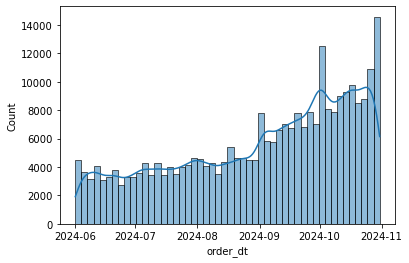

In [26]:
# Посмотрим на распределение числа проданных билетов по датам
sns.histplot(df['order_dt'], bins=50, kde=True)
plt.show()

Распределение выглядит реалистично, наблюдается ярко выраженная сезонность по месяцам.

In [27]:
# Подсчитаем количество отфильтрованных строк
filtered_rows = initial_rows - df.shape[0]
print(f'Отфильтровано строк: {filtered_rows}')

Отфильтровано строк: 2825


**Промежуточные выводы:**
1. Конвертация валют
    - Загружены курсы тенге к рублю за 2024 год
    - Выручка в тенге конвертирована в рубли: revenue_rub = revenue_kzt × (curs / 100)
    - Создан новый столбец revenue_rub с выручкой в единой валюте
2. Проверка и обработка данных
    - Пропуски: обнаружены только в days_since_prev (21 933 записи) - соответствует данным о первых заказах
    - Типы данных: оптимизированы для экономии памяти (24.4 МБ)
    - Категории: проверены, аномалий не обнаружено
3. Анализ ключевых показателей
    - Выручка (revenue_rub). Среднее: 625.58 руб, медиана: 356.01 руб. Обнаружено 5 907 отрицательных и нулевых значений (возвраты/отмены)
    - Билеты (tickets_count). Среднее: 2.75 билета на заказ, медиана: 3 билета
4. Обработка выбросов
    - Отфильтрованы значения revenue_rub выше 99-го перцентиля (4 000.19 руб.)
    - Удалено: 2 907 записей (1%). Средняя выручка: снизилась до 538.07 руб. Медиана: снизилась до 347.9 руб. Стандартное отклонение: уменьшилось в 2 раза (1 228 → 564 руб.)
5. Распределение данных
    - Устройства: mobile (79.9%), desktop (20.1%)
    - Валюты: RUB (98.2%), KZT (1.8%)
    - Типы событий: концерты (39.6%), театр (23.2%), другое (22.7%)
    - Распределение продаж по датам: наблюдается сезонность, продажи значительно увеличиваются в осенние месяцы
6. Итоги
    - Исходно: 290 611 записей
    - После обработки: 287 704 записи
    - Сокращение: 1% данных

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


Провести сортировку по времени совершенного заказа

Использовать будем столбец order_ts для определения первого заказа, так как может приходится по несколько заказов на один день

In [28]:
# Проводим сортировку данных по времени совершения заказа по возрастанию
user_profile = df.sort_values(by='order_ts')

# Проводим агрегацию по интересущим признакам
user_profile = user_profile.groupby('user_id').agg({
    'order_ts': ['min', 'max'],
    'device_type_canonical': 'first',
    'region_name': 'first',
    'service_name': 'first',
    'event_type_main': 'first',
    'order_id': 'count',
    'revenue_rub': 'mean',
    'tickets_count': 'mean',
    'days_since_prev': 'mean'
})

# Создаем функции добавления столбцов с бинарными признаками
def is_two(x):
    if x >= 2:
        return True
    else:
        return False
def is_five(x):
    if x >= 5:
        return True
    else:
        return False

# Добавляем столбцы с бинарными признаками по количеству совершенных заказов
user_profile['is_two'] = user_profile[('order_id', 'count')].apply(is_two)
user_profile['is_five'] = user_profile[('order_id', 'count')].apply(is_five)

# Избавляемся от мультииндекса для удобства в дальнейшем анализе
user_profile.columns = ['_'.join(col).strip('_') for col in user_profile.columns.values]
user_profile = user_profile.reset_index()

# Округляем значения в столбцах
user_profile[['revenue_rub_mean', 'tickets_count_mean', 'days_since_prev_mean']] = \
user_profile[['revenue_rub_mean', 'tickets_count_mean', 'days_since_prev_mean']].round(2)

# Проверяем полученный датафрейм
user_profile.head()

,user_id,order_ts_min,order_ts_max,device_type_canonical_first,region_name_first,service_name_first,event_type_main_first,order_id_count,revenue_rub_mean,tickets_count_mean,days_since_prev_mean,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.00,NaN,False,False
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,Каменевский регион,Мой билет,выставки,2,774.010010,3.00,75.0,True,False
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,Североярская область,Лови билет!,другое,3,767.210022,2.67,51.0,True,False
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,Каменевский регион,Край билетов,театр,1,917.830017,4.00,NaN,False,False
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,Поленовский край,Лучшие билеты,театр,2,61.310001,1.50,16.0,True,False


In [29]:
user_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21854 entries, 0 to 21853
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   user_id                      21854 non-null  object        
 1   order_ts_min                 21854 non-null  datetime64[ns]
 2   order_ts_max                 21854 non-null  datetime64[ns]
 3   device_type_canonical_first  21854 non-null  category      
 4   region_name_first            21854 non-null  object        
 5   service_name_first           21854 non-null  object        
 6   event_type_main_first        21854 non-null  category      
 7   order_id_count               21854 non-null  int64         
 8   revenue_rub_mean             21854 non-null  float32       
 9   tickets_count_mean           21854 non-null  float64       
 10  days_since_prev_mean         13521 non-null  float32       
 11  is_two                       21854 non-nu

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [30]:
print('Общее число пользователей в выборке:', user_profile['user_id'].nunique())
print('Средняя выручка с одного заказа:', round(user_profile['revenue_rub_mean'].mean(), 2))
print('Доля пользователей, совершивших 2 и более заказа:', round((user_profile['is_two'].sum() / user_profile['user_id'].nunique()) * 100, 2),'%')
print('Доля пользователей, совершивших 5 и более заказов:', round((user_profile['is_five'].sum() / user_profile['user_id'].nunique()) * 100, 2),'%')
print('-'*10)
print("Статистические показатели:")
user_profile[['order_id_count', 'tickets_count_mean', 'days_since_prev_mean']].describe()

Общее число пользователей в выборке: 21854
Средняя выручка с одного заказа: 544.4
Доля пользователей, совершивших 2 и более заказа: 61.71 %
Доля пользователей, совершивших 5 и более заказов: 29.01 %
----------
Статистические показатели:


,order_id_count,tickets_count_mean,days_since_prev_mean
count,21854.000000,21854.000000,13521.000000
mean,13.168573,2.743136,15.836082
std,121.674800,0.913090,22.298206
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000
50%,2.000000,2.750000,8.000000
75%,5.000000,3.080000,20.400000
max,10181.000000,11.000000,148.000000


По итогу анализа мы имеем данные о 21 854 пользователе, средней выручке за один билет, среднее число приобретенных билетов и среднее время между совершением заказов в рассчете на одного пользователя, этого объема данных достаточно для продолжения анализа.  

Явная аномалия наблюдается в столбце `order_id_count`, присутствуют выбросы, которые сильно влияют на средние показатели (стандартное отклонение в 121 билет - это очень много при медиане 2). Выбросы скорее всего обусловлены наличием аккаунтов, занимающихся перепродажей билетов. Необходимо провести фильтрацию данных, для составление более реалистичной картины данных.

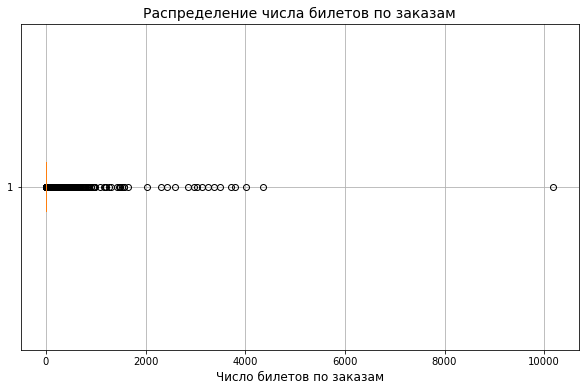

In [31]:
plt.figure(figsize=(10,6))
plt.boxplot(user_profile['order_id_count'], vert=False)
plt.title('Распределение числа билетов по заказам', fontsize=14)
plt.grid(True)
plt.xlabel('Число билетов по заказам', fontsize=12)
plt.show()

In [32]:
# Проводим фильтрацию по 99 процентилю
order_count_filtered = user_profile['order_id_count'].quantile(0.99)
user_profile_filtered = user_profile.loc[user_profile['order_id_count'] <= order_count_filtered]
user_profile_filtered['order_id_count'].describe()

count    21638.000000
mean         6.501294
std         14.324031
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        152.000000
Name: order_id_count, dtype: float64

In [33]:
# Проводим фильтрацию по 95 процентилю 
order_count_filtered2 = user_profile['order_id_count'].quantile(0.95)
user_profile_filtered2 = user_profile.loc[user_profile['order_id_count'] <= order_count_filtered2]
user_profile_filtered2['order_id_count'].describe()

count    20761.000000
mean         4.049564
std          5.113359
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         31.000000
Name: order_id_count, dtype: float64

In [34]:
user_profile['order_id_count'].shape[0] - user_profile_filtered['order_id_count'].shape[0]

216

In [35]:
user_profile['order_id_count'].shape[0] - user_profile_filtered2['order_id_count'].shape[0]

1093

В первом случае отфильтровано: 216 строк из 21854  

Во втором случае отфильтровано: 1093 строк из 21854  

При фильтрации по 95 процентилю мы получаем более реалистичную репрезентацию данных для типичного пользователя, по сравнению с фильтрацией по 99 процентилю (стандарное отклонение 5 при медиане 2, против стандартного отклонения 14 при сохранении медианы 2. Принято решение провести фильтрацию по 95 процентилю. Таким образом мы теряем 5% данных, что является приемлимым компромиссом для значительного улучшения чистоты данных.

In [36]:
# Выведем статистические показатели по отфильтрованному датасету
print('Общее число пользователей в выборке:', user_profile_filtered2['user_id'].nunique())
print('Средняя выручка с одного заказа:', round(user_profile_filtered2['revenue_rub_mean'].mean(), 2))
print('Доля пользователей, совершивших 2 и более заказа:', round((user_profile_filtered2['is_two'].sum() / user_profile_filtered2['user_id'].nunique()) * 100, 2),'%')
print('Доля пользователей, совершивших 5 и более заказов:', round((user_profile_filtered2['is_five'].sum() / user_profile_filtered2['user_id'].nunique()) * 100, 2),'%')
print('-'*10)
print("Статистические показатели:")
user_profile_filtered2[['order_id_count', 'tickets_count_mean', 'days_since_prev_mean']].describe()

Общее число пользователей в выборке: 20761
Средняя выручка с одного заказа: 546.68
Доля пользователей, совершивших 2 и более заказа: 59.69 %
Доля пользователей, совершивших 5 и более заказов: 25.27 %
----------
Статистические показатели:


,order_id_count,tickets_count_mean,days_since_prev_mean
count,20761.000000,20761.000000,12428.000000
mean,4.049564,2.743603,17.038754
std,5.113359,0.934549,22.866970
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000
50%,2.000000,2.750000,9.460000
75%,5.000000,3.150000,22.000000
max,31.000000,11.000000,148.000000


По итогу фильтрации мы получили более репрезентативные данные, пригодные для дальнейшего анализа. Удаление выбросов повлияло незначительно на статистические показатели в столбцах `tickets_count_mean` и `days_since_prev_mean`, что подтверждает оправданность принятого решения.

**Промежуточные выводы:**
1. Формирование пользовательских профилей
    - Успешно созданы агрегированные профили для 21,854 пользователей
    - Для каждого пользователя рассчитаны ключевые метрики поведения: история заказов, устройства, регионы, предпочтения по жанрам и партнерам
    - Добавлены бинарные признаки активности (is_two, is_five) для дальнейшего анализа лояльности
2. Общая статистика пользовательской базы
    - Пользователи в среднем совершают 13 заказов, однако медиана составляет всего 2 заказа — распределение сильно скошено вправо
    - 61.7% пользователей совершили 2 и более заказа, 29.0% — 5 и более заказов
    - Средняя выручка с заказа составляет 544.4 рубля
    - Среднее время между заказами — 15.8 дней
3. Обнаружение и обработка аномалий
    - Выявлены крайние выбросы в количестве заказов: максимальное значение 10,181 заказ при медиане 2
    - Для повышения репрезентативности профиля "среднестатистического пользователя" применена фильтрация по 95-му перцентилю
    - Удалено 5% пользователей (1,093 чел.) с аномально высокой активностью (>31 заказа)
    - В отфильтрованной выборке (20,761 пользователь) среднее количество заказов снизилось до 4.05 при сохранении медианы 2
4. Качество итоговых данных
    - Очищенный датасет репрезентативен: сохранено 95% исходных данных
    - Показатели стали более реалистичными: устранено влияние экстремальных выбросов
    - Распределения приблизились к нормальному: стандартное отклонение по заказам снизилось с 121.7 до 5.1

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [37]:
# Для удобство переименуем отфильтрованный датафрейм с профилем пользователей
profile_clear = user_profile_filtered2

In [38]:
# Проведем группировку по признакам первого совершенного пользователем заказа:

# по типу мероприятия
first_event_seg = profile_clear.groupby('event_type_main_first')['user_id'].count().sort_values(ascending=False)

# по типу устройства 
first_device_seg = profile_clear.groupby('device_type_canonical_first')['user_id'].count().sort_values(ascending=False)

# по названию региона
first_region_seg = profile_clear.groupby('region_name_first')['user_id'].count().sort_values(ascending=False)

# по сервису продажи билетов
first_service_seg = profile_clear.groupby('service_name_first')['user_id'].count().sort_values(ascending=False)

In [39]:
# Подсчитаем долю пользователей в каждом сегменте в процентах:

# по типу мероприятия
first_event_share = round(first_event_seg / profile_clear['user_id'].count() * 100, 2)

# по типу устройства 
first_device_share = round(first_device_seg / profile_clear['user_id'].count() * 100, 2)

# по названию региона
first_region_share = round(first_region_seg / profile_clear['user_id'].count() * 100, 2)

# по сервису продажи билетов
first_service_share = round(first_service_seg / profile_clear['user_id'].count() * 100, 2)

In [40]:
# Выведем данные по типам мероприятий
print('Общее количество пользователей по типу мероприятий:')
print(first_event_seg)
print('-'*10)
print('Доля в разрезе типа мероприятия:')
print(first_event_share)

Общее количество пользователей по типу мероприятий:
event_type_main_first
концерты    9188
другое      5175
театр       4068
стендап     1069
спорт        765
выставки     402
ёлки          94
Name: user_id, dtype: int64
----------
Доля в разрезе типа мероприятия:
event_type_main_first
концерты    44.26
другое      24.93
театр       19.59
стендап      5.15
спорт        3.68
выставки     1.94
ёлки         0.45
Name: user_id, dtype: float64


Пользователи неравномерно распределены по типам мероприятия: концерты и театры занимают примерно 68% продаж. Важным сегментом являются мероприятия без определенной категории в сегменте "другое", это около четверти мероприятий.  

In [41]:
# Выведем данные по типам устройств
print('Общее количество пользователей по типу устройства:')
print(first_device_seg)
print('-'*10)
print('Доля в разрезе типа устройства:')
print(first_device_share)

Общее количество пользователей по типу устройства:
device_type_canonical_first
mobile     17222
desktop     3539
Name: user_id, dtype: int64
----------
Доля в разрезе типа устройства:
device_type_canonical_first
mobile     82.95
desktop    17.05
Name: user_id, dtype: float64


Здесь пользователи также распределены неравномерно: абсолютное большинство (83%) совершают свой первый заказ с мобильного телефона. Эти показатели примерно соответствуют общей статистике используемых устройств для совершения заказов.

In [42]:
# Выведем данные по названию регионов
print('Общее количество пользователей по названию региона:')
print(first_region_seg)
print('-'*10)
print('Доля в разрезе названия региона:')
print(first_region_share)

Общее количество пользователей по названию региона:
region_name_first
Каменевский регион          6780
Североярская область        3598
Широковская область         1184
Озернинский край             660
Малиновоярский округ         515
                            ... 
Залесский край                 2
Верхозёрский край              1
Светолесский край              1
Сосноводолинская область       1
Яснопольский округ             1
Name: user_id, Length: 81, dtype: int64
----------
Доля в разрезе названия региона:
region_name_first
Каменевский регион          32.66
Североярская область        17.33
Широковская область          5.70
Озернинский край             3.18
Малиновоярский округ         2.48
                            ...  
Залесский край               0.01
Верхозёрский край            0.00
Светолесский край            0.00
Сосноводолинская область     0.00
Яснопольский округ           0.00
Name: user_id, Length: 81, dtype: float64


Наибольшее число продаж (50%) приходится на два региона: Каменевский регион и Североярская область. Присутствуют регионы незначительно влияющие на общую картину с минимальным количеством проведенных мероприятий. 

In [43]:
# Выведем данные по сервисам продажи билетов:
print('Общее количество пользователей по сервисам продажи билетов:')
print(first_service_seg)
print('-'*10)
print('Доля в разрезе сервисов продажи билетов:')
print(first_service_share)

Общее количество пользователей по сервисам продажи билетов:
service_name_first
Билеты без проблем        4970
Мой билет                 2852
Лови билет!               2707
Билеты в руки             2426
Облачко                   2108
Весь в билетах            1233
Лучшие билеты             1132
Прачечная                  550
Край билетов               438
Дом культуры               340
Яблоко                     308
Тебе билет!                299
Городской дом культуры     209
Мир касс                   198
За билетом!                196
Быстробилет                159
Show_ticket                154
Выступления.ру              92
Восьмёрка                   82
Быстрый кассир              55
Crazy ticket!               42
Росбилет                    40
Радио ticket                36
Реестр                      27
Телебилет                   27
Цвет и билет                21
Шоу начинается!             18
КарандашРУ                  14
Кино билет                   9
Вперёд!               

Половина продаж приходится на топ-3 сервиса, на топ-10 приходится 90%, доля продаж большей части сервисов составляют менее 1%.

Распределение крайне неравномерное по всем признакам:

- Тип мероприятия: Концерты (44%) + Другое (25%) + Театр (20%) = 89% всех заказов

- Устройство: Мобильные (83%) vs Десктоп (17%) - явное доминирование

- Регион: Каменевский регион (33%) + Североярская область (17%) = 50% всех заказов

- Сервис: Топ-3 сервиса дают ~51%, топ-10 - ~90%

Выраженные "точки входа":

- Мобильные пользователи на концертах

- В Каменевском регионе

- Через сервис "Билеты без проблем"

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [44]:
# Проведем расчет доли пользователей, совершивших два и более заказов в разрезе их первого типа мероприятия
users_with_two_plus_by_event = profile_clear[profile_clear['is_two'] == 1].groupby('event_type_main_first')['user_id'].count()
first_event_return_rate = (users_with_two_plus_by_event / first_event_seg * 100).round(2)
first_event_return_rate.sort_values(ascending=False)

event_type_main_first
выставки    62.94
театр       61.85
концерты    60.29
стендап     59.40
другое      57.66
ёлки        55.32
спорт       54.12
Name: user_id, dtype: float64

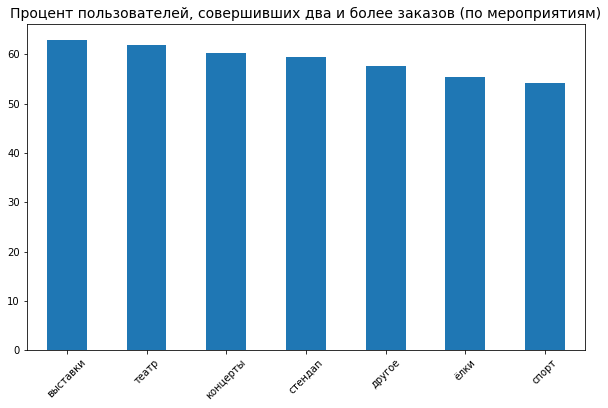

In [45]:
# Посторим диаграмму для визуализации полученных данных
first_event_return_rate.sort_values(ascending=False).plot(kind='bar', rot=45, figsize=(10,6))
plt.title('Процент пользователей, совершивших два и более заказов (по мероприятиям)', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.show()

Можно сделать вывод, что вероятность возвращения пользователя мало зависит от их первого типа мероприятия.

In [46]:
# Проведем расчет доли пользователей, совершивших два и более заказов в разрезе используемого устройства
users_with_two_plus_by_device = profile_clear[profile_clear['is_two'] == 1].groupby('device_type_canonical_first')['user_id'].count()
first_device_return_rate = (users_with_two_plus_by_device / first_device_seg * 100).round(2)
first_device_return_rate.sort_values(ascending=False)

device_type_canonical_first
desktop    62.02
mobile     59.21
Name: user_id, dtype: float64

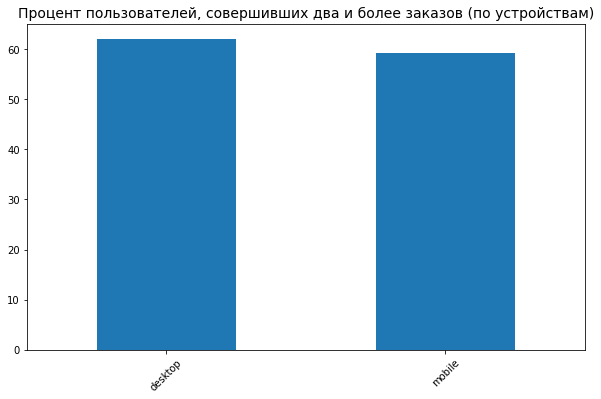

In [47]:
# Посторим диаграмму для визуализации полученных данных
first_device_return_rate.sort_values(ascending=False).plot(kind='bar', rot=45, figsize=(10,6))
plt.title('Процент пользователей, совершивших два и более заказов (по устройствам)', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.show()

Вероятность возврата пользователя не зависит от типа используемого устройства при совершении первого заказа (62% для мобильных устройств и 59% для ПК)

In [48]:
# Проведем расчет доли пользователей, совершивших два и более заказов по названию региона
users_with_two_plus_by_region = profile_clear[profile_clear['is_two'] == 1].groupby('region_name_first')['user_id'].count()
first_region_return_rate = (users_with_two_plus_by_region / first_region_seg * 100).round(2)
first_region_return_rate.sort_values(ascending=False)

region_name_first
Верхозёрский край           100.00
Озернопольская область       88.89
Радужнопольский край         76.19
Лесостепной край             69.09
Тихолесский край             66.67
                             ...  
Теплоозёрский округ          33.33
Островогорский округ           NaN
Светолесский край              NaN
Сосноводолинская область       NaN
Яснопольский округ             NaN
Name: user_id, Length: 81, dtype: float64

In [49]:
# Выведем отдельно данные для топ-10 регионов
first_region_return_rate.sort_values(ascending=False).head(10)

region_name_first
Верхозёрский край         100.00
Озернопольская область     88.89
Радужнопольский край       76.19
Лесостепной край           69.09
Тихолесский край           66.67
Лесноярский край           66.67
Горноземский регион        65.38
Ягодиновская область       65.00
Шанырский регион           64.50
Горицветская область       64.35
Name: user_id, dtype: float64

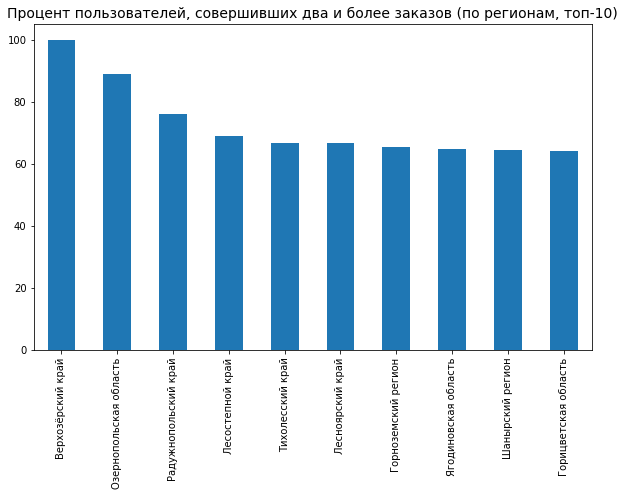

In [50]:
# Посторим диаграмму для визуализации полученных данных
first_region_return_rate.sort_values(ascending=False).head(10).plot(kind='bar', rot=90, figsize=(10,6))
plt.title('Процент пользователей, совершивших два и более заказов (по регионам, топ-10)', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.show()

Анализ топ-10 регионов показывает наличие трех лидеров: Верхозёрский край, Озернопольская область, Радужнопольский край. Но: это сегменты с 1–27 пользователями, результат ненадёжен. Для остальных семи регионов из топа доли возвращающихся пользователей примерно равны (64-69%). Присутствует 4 региона, где пользователи ни разу не сделали повторный заказ.

In [51]:
# Проведем расчет доли пользователей, совершивших два и более заказов в разрезе их первого типа мероприятия
users_with_two_plus_by_service = profile_clear[profile_clear['is_two'] == 1].groupby('service_name_first')['user_id'].count()
first_service_return_rate = (users_with_two_plus_by_service / first_service_seg * 100).round(2)
first_service_return_rate.sort_values(ascending=False)

service_name_first
Зе Бест!                  100.00
Быстрый кассир             83.64
Билет по телефону          83.33
Реестр                     77.78
Восьмёрка                  67.07
Crazy ticket!              66.67
Росбилет                   65.00
Show_ticket                64.29
Край билетов               63.93
Дом культуры               62.94
Мир касс                   62.63
Цвет и билет               61.90
Весь в билетах             61.31
Выступления.ру             60.87
Билеты в руки              60.68
Прачечная                  60.36
Облачко                    60.01
Лучшие билеты              59.45
Лови билет!                59.44
Мой билет                  59.26
Тебе билет!                59.20
Билеты без проблем         58.69
Быстробилет                58.49
За билетом!                57.65
Городской дом культуры     57.42
Вперёд!                    57.14
Кино билет                 55.56
Яблоко                     51.95
Лимоны                     50.00
Телебилет               

In [52]:
# Выведем отдельно топ-10 сервисов по числу вернувшихся клиентов
first_service_return_rate.sort_values(ascending=False).head(10)

service_name_first
Зе Бест!             100.00
Быстрый кассир        83.64
Билет по телефону     83.33
Реестр                77.78
Восьмёрка             67.07
Crazy ticket!         66.67
Росбилет              65.00
Show_ticket           64.29
Край билетов          63.93
Дом культуры          62.94
Name: user_id, dtype: float64

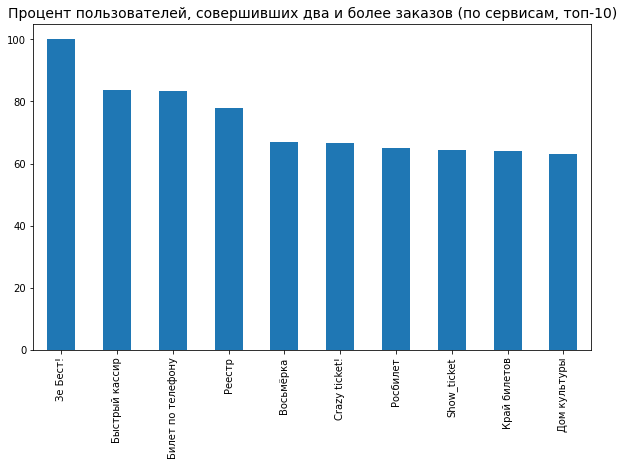

In [53]:
# Посторим диаграмму для визуализации полученных данных
first_service_return_rate.sort_values(ascending=False).head(10).plot(kind='bar', rot=90, figsize=(10,6))
plt.title('Процент пользователей, совершивших два и более заказов (по сервисам, топ-10)', fontsize=14)
plt.xlabel('')
plt.show()

Анализ топ-10 сервисов показывает наличие четырех лидеров: Зе Бест!, Быстрый кассир, Билет по телефону, Реестр. Но: это сегменты с 1–55 пользователями, результат ненадёжен. Доли возвращающих пользователей среди остальных сервисов из топа примерно одинаковы (63-67%). Доли из общего списка сервисов распределены в диапазоне (28-100%).

**Ответы на вопросы задачи:**
1. Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
- Тип мероприятия:
    - Выставки (62.94%), Театр (61.85%), Концерты (60.29%) Но разница минимальна, статистически может быть незначима
- Тип устройства:
    - Desktop (62.02%) vs Mobile (59.21%) Небольшое преимущество у пользователей ПК
- Регионы (топ-10):
    - Лидеры: Верхозёрский край (100%), Озернопольская область (88.89%), Радужнопольский край (76.19%) Но важно: Это малые сегменты (1-27 пользователей) → результаты ненадежны
- Сервисы (топ-10):
    - Лидеры: Зе Бест! (100%), Быстрый кассир (83.64%), Билет по телефону (83.33%) Но важно: Малые сегменты (1-55 пользователей) → результаты ненадежны

2. Наблюдаются ли успешные «точки входа»?
- Присутствуют кажущиеся успешные, но ненадежные точки входа: Верхозёрский край (100%) - всего 1 пользователь, Зе Бест! (100%) - всего 1 пользователь, Билет по телефону (83.33%) - всего 6 пользователей
- Выраженные статистически надежные точки входа отсутствуют.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

**Гипотеза 1:** Тип мероприятия влияет на вероятность возврата: пользователи, впервые купившие билеты на спорт, возвращаются чаще, чем впервые купившие на концерты.

Проверка по данным:

- Возвращаемость после первого заказа на спорт — 54,12%

- Возвращаемость после первого заказа на концерты — 60,29%

Вывод: Гипотеза не подтверждается. Пользователи, начавшие со спортивных мероприятий, возвращаются реже, чем начавшие с концертов (разница ≈ 6 п.п.). Более того, спорт показывает наименьшую возвращаемость среди всех категорий мероприятий.

**Гипотеза 2:** В регионах с наибольшим числом пользователей доля повторных заказов выше, чем в менее активных регионах.

Проверка по данным:

- Каменевский регион (наибольшее число пользователей — 32,7% от всех) — возвращаемость 59,97%

- Североярская область (второй по размеру — 17,3%) — возвращаемость 60,31%

- Средняя возвращаемость по выборке — ~60%

Вывод: Гипотеза не подтверждается. Крупнейшие регионы не показывают повышенной возвращаемости — их показатели близки к среднему по платформе. Более того, некоторые регионы с высокой возвращаемостью (например, Верхозёрский край — 100%) крайне малочисленны, что делает их статистически ненадёжными, а не примерами успешной «точки входа».

**Общий итог:** Обе гипотезы отклоняются. Данные не показывают значимой связи между типом первого мероприятия или размером региона и вероятностью повторного заказа. Возвращаемость пользователей достаточно равномерна по крупным сегментам, что говорит об устойчивости платформы, но отсутствии выраженных «точек входа» с повышенной лояльностью.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


Распределение средней выручки отличается между двумя группами пользователей:

- Пользователи с одним заказом концентрируются в области более низкой средней выручки (0-200 руб.) и имеют более острый пик.
- Пользователи с более чем одним заказом имеют пик в районе больших значений (300-600 руб.) и более широкое распределение.


In [54]:
# Отберем пользователей, имеющих два и более заказов
profile_clear_is_two = profile_clear.loc[profile_clear['is_two'] == 1]

In [55]:
# Создаем копии имеющихся датафреймов с пользовательскими профилями
revenue_hist = profile_clear.copy()
revenue_hist2 = profile_clear_is_two.copy()

# Выделим новый столбец с рассчитанной средней стоимостью билета в заказе
revenue_hist['avg_revenue_rub'] = revenue_hist['revenue_rub_mean'] / revenue_hist['tickets_count_mean']
revenue_hist2['avg_revenue_rub'] = revenue_hist2['revenue_rub_mean'] / revenue_hist2['tickets_count_mean']

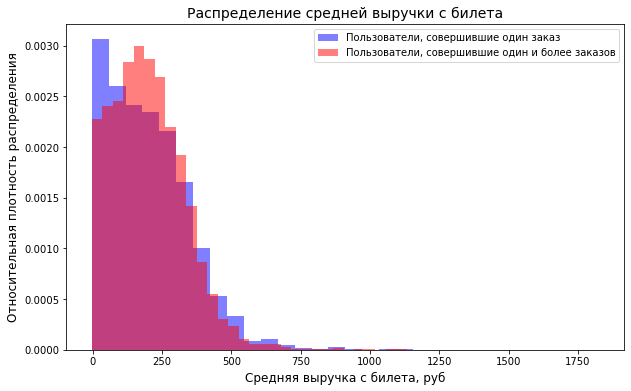

In [56]:
# Построим диаграммы распределения средней выручки с билета
fig, ax = plt.subplots(figsize=(10, 6))
revenue_hist['avg_revenue_rub'].plot.hist(alpha=0.5, density=True, bins=30,
                        label='Пользователи, совершившие один заказ', ax=ax, color='blue')
revenue_hist2['avg_revenue_rub'].plot.hist(alpha=0.5, density=True, bins=30, 
                        label='Пользователи, совершившие один и более заказов', ax=ax, color='red')
ax.legend()
ax.set_ylabel('Относительная плотность распределения', fontsize=12)
ax.set_xlabel('Средняя выручка с билета, руб', fontsize=12)
ax.set_title('Распределение средней выручки с билета', fontsize=14)
plt.show()

Диапазоны концентрации пользователей:

- 1 заказ: 0-200 рублей за билет (пик: 50-100 руб)

- 2+ заказа: 50-300 рублей за билет (пик: 100-250 руб)

Различия между группами:

- Возвращающиеся пользователи покупают более дорогие билеты

- У них более широкое распределение по цене

- Меньшая доля очень дешевых билетов (0-100 руб)

- Большая доля билетов среднего ценового диапазона (200-400 руб)

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [57]:
# Отберем пользователей, совершивших 5 и более заказов
profile_clear_is_five = profile_clear.loc[profile_clear['is_five'] == 1]

# Отберем пользователей совершивших 2-4 заказа
profile_clear_two_four = profile_clear.loc[(profile_clear['is_two'] == 1) & (profile_clear['is_five'] != 1)] 

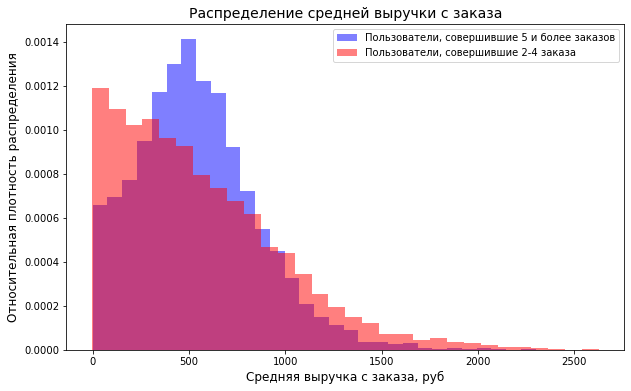

In [58]:
# Построим диаграммы распределения средней выручки с заказа
fig, ax = plt.subplots(figsize=(10, 6))
profile_clear_is_five['revenue_rub_mean'].plot.hist(alpha=0.5, density=True, bins=30,
                        label='Пользователи, совершившие 5 и более заказов', ax=ax, color='blue')
profile_clear_two_four['revenue_rub_mean'].plot.hist(alpha=0.5, density=True, bins=30, 
                        label='Пользователи, совершившие 2-4 заказа', ax=ax, color='red')
ax.legend()
ax.set_ylabel('Относительная плотность распределения', fontsize=12)
ax.set_xlabel('Средняя выручка с заказа, руб', fontsize=12)
ax.set_title('Распределение средней выручки с заказа', fontsize=14)
plt.show()

Группа "2-4 заказа":

- Широкое распределение с основным пиком в 0-500 рублей

- Значительная доля очень дешевых заказов (0-200 руб)

- Медленный спад после пика, длинный правый хвост

Группа "5+ заказов":

- Более узкое распределение с пиком в 300-700 рублей

- Минимальная доля очень дешевых заказов (0-200 руб)

- Более выраженный пик в среднем ценовом сегменте

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [59]:
profile_clear.head()

,user_id,order_ts_min,order_ts_max,device_type_canonical_first,region_name_first,service_name_first,event_type_main_first,order_id_count,revenue_rub_mean,tickets_count_mean,days_since_prev_mean,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.00,NaN,False,False
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,Каменевский регион,Мой билет,выставки,2,774.010010,3.00,75.0,True,False
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,Североярская область,Лови билет!,другое,3,767.210022,2.67,51.0,True,False
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,Каменевский регион,Край билетов,театр,1,917.830017,4.00,NaN,False,False
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,Поленовский край,Лучшие билеты,театр,2,61.310001,1.50,16.0,True,False


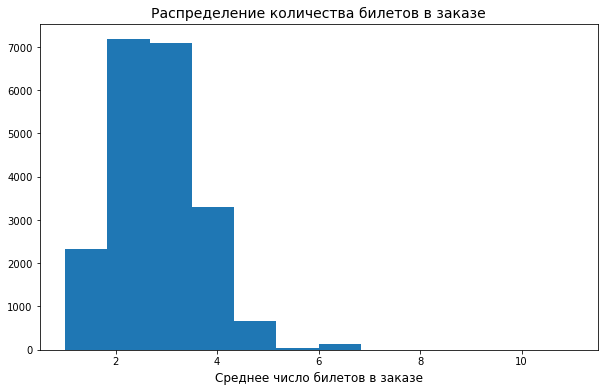

In [60]:
# Оценим распределение средненго количества билетов в заказах
profile_clear['tickets_count_mean'].plot(kind='hist', figsize=(10,6), bins=12)
plt.title('Распределение количества билетов в заказе', fontsize=14)
plt.xlabel('Среднее число билетов в заказе', fontsize=12)
plt.ylabel('')
plt.show()

У большинства пользователей в одном заказе 1-4 билета, самый популярный вариант: 2-3 билета.

In [61]:
# Создадим копию датафрейма
tickets_category = profile_clear.copy()

# Определим функцию делящую пользователей на категории
def categorize_tickets(value):
    if value < 2:
        return 'от 1 до 2 билетов'
    elif value < 3:  
        return 'от 2 до 3 билетов'
    elif value < 5: 
        return 'от 3 до 5 билетов'
    else: 
        return 'от 5 и более билетов' 

    # В созданной копии датафрейма создадим дполнительный столбец с категориями
tickets_category['avg_tickets_count'] = tickets_category['tickets_count_mean'].apply(categorize_tickets) 

In [62]:
# Подсчитаем общее число пользователей в каждом сегменте
tickets_grouped = tickets_category.groupby('avg_tickets_count')['user_id'].count()

# Выделим вернувшихся пользователей
tickets_category2 = tickets_category.loc[tickets_category['is_two'] == 1] 

# Подсчитаем число вернувшихся пользователей в каждом сегменте
tickets_grouped2 = tickets_category2.groupby('avg_tickets_count')['user_id'].count()

# Подсчитаем процент вернувшихся пользователей в каждом сегменте
tickets_grouped_share = round(tickets_grouped2 / tickets_grouped * 100, 2)

In [63]:
print(f'Общее количество пользователей в каждом сегменте: {tickets_grouped}')
print('-'*10)
print(f'Процент вернувшихся пользователей в каждом сегменте: {tickets_grouped_share}')

Общее количество пользователей в каждом сегменте: avg_tickets_count
от 1 до 2 билетов       2415
от 2 до 3 билетов       8759
от 3 до 5 билетов       8926
от 5 и более билетов     661
Name: user_id, dtype: int64
----------
Процент вернувшихся пользователей в каждом сегменте: avg_tickets_count
от 1 до 2 билетов       51.22
от 2 до 3 билетов       71.36
от 3 до 5 билетов       53.57
от 5 и более билетов    18.76
Name: user_id, dtype: float64



1. Пользователи распределены неравномерно со значительной концентрацией:

    - 84.3% пользователей покупают 2-5 билетов в среднем за заказ

    - 11.1% покупают 1-2 билета

    - Всего 3.0% покупают 5+ билетов  
    

2. Сегменты с аномальной долей повторных покупок
    - Высокая возвращаемость: "от 2 до 3 билетов" — 71.36%. Возможно, пользователи, покупающие 2-3 билета (пары, семьи), наиболее лояльны

    - Низкая возвращаемость: "от 5 и более билетов" — 18.76%. Возможно, пользователи, покупающие большие партии билетов (корпоративы, организаторы), почти не возвращаются

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [64]:
# Создаем копию датафрейма
profile_clear_day = profile_clear.copy()

# Выделим день недели из даты первого заказа
profile_clear_day['day_of_week'] = profile_clear_day['order_ts_min'].dt.strftime('%A') 

# Сгруппируем пользователей по дням недели
profile_day_grouped = profile_clear_day.groupby('day_of_week')['user_id'].count()

# Выделим пользователей, совершивших два и более заказов
profile_clear_day2 = profile_clear_day.loc[profile_clear_day['is_two'] == 1]

# Сгруппируем пользователей, совершивших два и более заказов, по дням недели
profile_day_grouped2 = profile_clear_day2.groupby('day_of_week')['user_id'].count()

# Подсчитаем долю вернувшихся пользователей в зависимости от дня недели
profile_day_share = round(profile_day_grouped2 / profile_day_grouped * 100, 2)

In [65]:
# Выведем полученные метрики
print(f'Распределение общего числа пользователей по дням недели: {profile_day_grouped}')
print('-'*10)
print(f'Процент от числа вернувшихся пользователей по дням недели: {profile_day_share}')

Распределение общего числа пользователей по дням недели: day_of_week
Friday       3166
Monday       2820
Saturday     3122
Sunday       2641
Thursday     3027
Tuesday      3025
Wednesday    2960
Name: user_id, dtype: int64
----------
Процент от числа вернувшихся пользователей по дням недели: day_of_week
Friday       58.65
Monday       61.60
Saturday     60.38
Sunday       57.97
Thursday     58.28
Tuesday      60.00
Wednesday    60.95
Name: user_id, dtype: float64


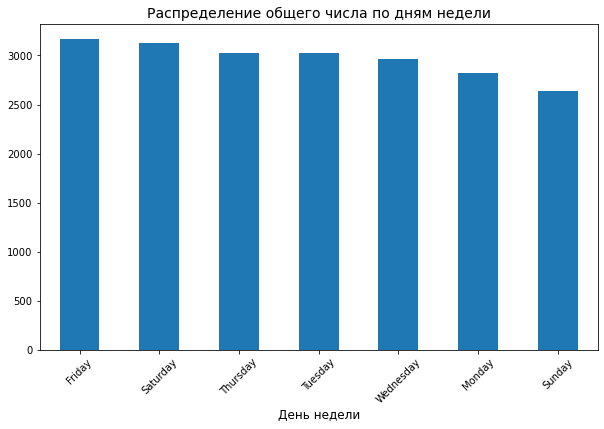

In [66]:
# Отобразим распределение общего числа пользователей по дням недели
profile_day_grouped.sort_values(ascending=False).plot(kind='bar', rot=45, figsize=(10,6))
plt.title('Распределение общего числа по дням недели', fontsize=14)
plt.xlabel('День недели', fontsize=12)
plt.show()

Распределение совершения первого заказа пользователями по дням недели достаточно равномерно.    
Видно, что чаще всего пользователи совершают заказ в пятницу, в конце рабочей недели. Меньше всего заказов приходится на воскресенье пред началом следующей рабочей недели. 

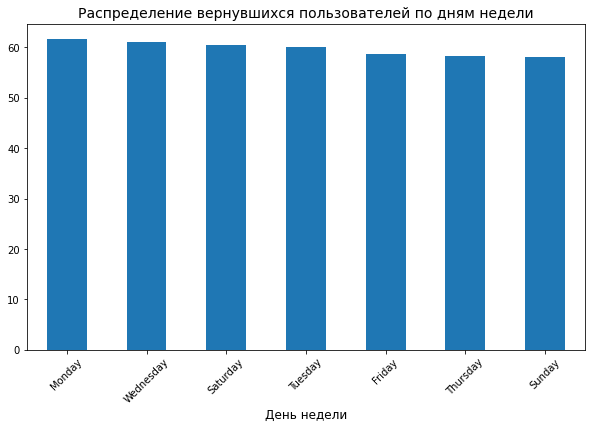

In [67]:
# Отобразим процент от числа вернувшихся пользователей по дням недели
profile_day_share.sort_values(ascending=False).plot(kind='bar', rot=45, figsize=(10,6))
plt.title('Распределение вернувшихся пользователей по дням недели', fontsize=14)
plt.xlabel('День недели', fontsize=12)
plt.show()

Вывод:   
День недели, в который была совершена первая покупка не оказывает значительного влияния на вероятность возврата пользователя.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [68]:
# Вычислим среднее время между заказами для пользователей с 2-4 заказами:
print('Среднее время между заказами для пользователей с 2-4 заказами:')
print(round(profile_clear_two_four['days_since_prev_mean'].mean(), 2), 'дня')

Среднее время между заказами для пользователей с 2-4 заказами:
21.32 дня


In [69]:
# Подсчитаем среднее время между заказами для пользователей совершивших 5 и более заказов
print('Среднее время между заказами для пользователей с 5+ заказами:')
print(round(profile_clear_is_five['days_since_prev_mean'].mean(), 2), 'дня')

Среднее время между заказами для пользователей с 5+ заказами:
11.13 дня


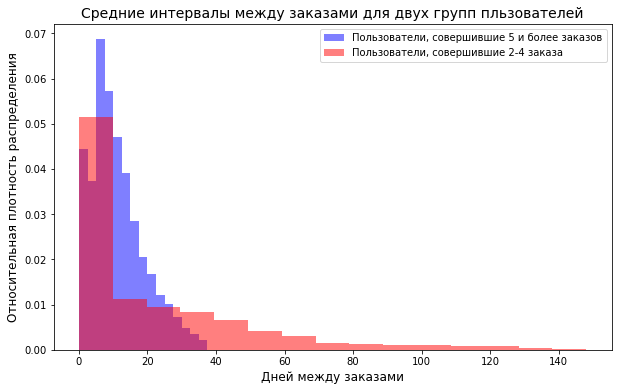

In [70]:
# Визуализируем распределение средних интервалов между заказами для двух групп пользователей
# Датафреймы с нужными группами пользователей возьмем из задачи 4.2.2
fig, ax = plt.subplots(figsize=(10, 6))
profile_clear_is_five['days_since_prev_mean'].plot.hist(alpha=0.5, density=True, bins=15,
                        label='Пользователи, совершившие 5 и более заказов', ax=ax, color='blue')
profile_clear_two_four['days_since_prev_mean'].plot.hist(alpha=0.5, density=True, bins=15, 
                        label='Пользователи, совершившие 2-4 заказа', ax=ax, color='red')
ax.legend()
ax.set_ylabel('Относительная плотность распределения', fontsize=12)
ax.set_xlabel('Дней между заказами', fontsize=12)
ax.set_title('Средние интервалы между заказами для двух групп пльзователей', fontsize=14)
plt.show()

Средний интервал между заказами сильно влияет на удержание клиентов и их переход в категорию высоколояльных пользователей.

1. Количественные различия:

    - 2-4 заказа: средний интервал = 21.3 дня, широкое распределение (10-40+ дней)

    - 5+ заказов: средний интервал = 11.1 дня, узкое распределение (5-20 дней)

2. Ключевые закономерности:

    - Обратная зависимость: чем короче средний интервал между заказами, тем выше вероятность стать суперлояльным клиентом (5+ заказов)

    - Критический порог: интервалы более 30 дней практически исключают переход в категорию 5+ заказов

    - Оптимальный диапазон: для формирования высокой лояльности оптимальный интервал между заказами составляет 5-15 дней

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [71]:
# Создаем копию датасета
corr_columns = profile_clear.copy()

# Из даты первого заказа выделим месяц и неделю первого заказа для изучения корреляция с сезонностью 
corr_columns['order_ts_min_month'] = corr_columns['order_ts_min'].dt.month
corr_columns['order_ts_min_week'] = corr_columns['order_ts_min'].dt.isocalendar().week

# Оставим необходимые колонки для построения корреляционной матрицы
corr_columns = corr_columns[['device_type_canonical_first', 'region_name_first',
       'service_name_first', 'event_type_main_first', 'order_id_count',
       'revenue_rub_mean', 'tickets_count_mean', 'days_since_prev_mean',
       'order_ts_min_month', 'order_ts_min_week']]

In [72]:
# Строим корреляционную матрицу
corr_matrix = corr_columns.phik_matrix(interval_cols=['order_id_count', 'revenue_rub_mean', 'tickets_count_mean',
                                                      'days_since_prev_mean', 'order_ts_min_month', 'order_ts_min_week'])

In [73]:
# Выведем коэффициент для числа заказов в порядке убывания
corr_matrix['order_id_count'].sort_values(ascending=False)

order_id_count                 1.000000
days_since_prev_mean           0.490106
order_ts_min_month             0.458601
order_ts_min_week              0.425500
tickets_count_mean             0.296873
revenue_rub_mean               0.265566
device_type_canonical_first    0.050118
service_name_first             0.038566
event_type_main_first          0.033819
region_name_first              0.000000
Name: order_id_count, dtype: float64

Корреляционная матрица построена успешно, существует связь общего количества заказов пользователя с временными и количественными метриками.   

Уточним полученные данные, дполнительно разделив столбец `order_id_count` на категории, т.к. коэффициент p_hik лучше работает с категориальными данными, чем с числовыми. В нашем случае категориальный подход будет точнее.

In [74]:
# Создадим функцию для сегментирования числа заказов
def total_orders_segments(value):
    if value == 1:
        return '1 заказ'
    elif 2 <= value <= 4:
        return 'от 2 до 4 заказов'
    else:
        return 'от 5 и выше'

# Разделяем общее число заказов на группы по количеству
corr_columns['order_segments'] = corr_columns['order_id_count'].apply(total_orders_segments)

In [75]:
# Обновляем столбцы для построения новой корреляционной матрицы
corr_columns = corr_columns[['device_type_canonical_first', 'region_name_first',
       'service_name_first', 'event_type_main_first',
       'revenue_rub_mean', 'tickets_count_mean', 'days_since_prev_mean',
       'order_ts_min_month', 'order_ts_min_week', 'order_segments']]

In [76]:
# Поменяем названия исходных колонок для лучшей читаемости
corr_columns.columns = ["устройство первого заказа", "регион первого заказа",
                        "сервис первого заказа", "мероприятие первого заказа",
                        "средняя выручка", "среднее количество билетов",
                        "среднее время между заказами", "месяц первого заказа",
                        "неделя первого заказа", "сегменты заказов"]

In [77]:
# Строим обновленную корреляционную матрицу
corr_matrix_update = corr_columns.phik_matrix(interval_cols=['средняя выручка', 'среднее количество билетов',
                                                            'среднее время между заказами', 'месяц первого заказа',
                                                            'неделя первого заказа'])

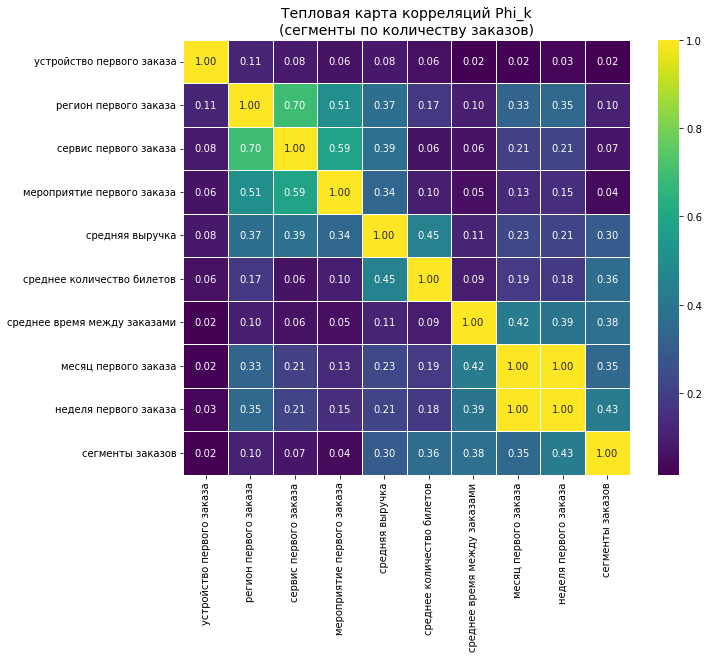

In [78]:
# Визулизируем корреляционную марицу с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_update, 
            annot=True, 
            fmt='.2f', 
            cmap='viridis',
            linewidths=0.5)
plt.title('Тепловая карта корреляций Phi_k\n(сегменты по количеству заказов)', fontsize=14)
plt.show()

In [79]:
# Выведем полученные коэффициенты для общего числа заказов
corr_matrix_update['сегменты заказов'].sort_values(ascending=False).round(3)

сегменты заказов                1.000
неделя первого заказа           0.427
среднее время между заказами    0.377
среднее количество билетов      0.359
месяц первого заказа            0.345
средняя выручка                 0.299
регион первого заказа           0.105
сервис первого заказа           0.072
мероприятие первого заказа      0.040
устройство первого заказа       0.015
Name: сегменты заказов, dtype: float64

Вывод по корреляционному анализу:  


Наиболее значимые предикторы количества заказов — временные и количественные метрики первого заказа, а не демографические характеристики пользователей.  


1. Сильно связанные признаки (Phi_k > 0.3):

    - Неделя первого заказа (0.427) — сезонность привлечения влияет на лояльность

    - Месяц первого заказа (0.345) — время года имеет значение

    - Средний интервал между заказами (0.377) — чем чаще возвращается, тем выше лояльность

    - Среднее количество билетов (0.359) — более крупные покупки коррелируют с большим числом заказов   
    

2. Умеренно связанные признаки (0.1 < Phi_k < 0.3):  

    - Месяц первого заказа (0.345) — время года имеет значение
    - Средняя выручка за заказ (0.299) — более дорогие покупки → больше заказов
    - Регион (0.105) — географический фактор минимально влияет



**Промежуточный вывод:** 
1. Характеристики первого заказа НЕ являются надежными предикторами лояльности:
- Распределение пользователей крайне неравномерно (концерты 44%, мобильные 83%)

- Различия в возвращаемости между сегментами минимальны (54-63%)

- Вывод: Не стоит фокусировать стратегию удержания на демографических или событийных признаках

2. Поведенческие метрики — ключ к пониманию лояльности:
Размер заказа: Пользователи с 2-3 билетами возвращаются в 3.8 раза чаще, чем с 5+ билетами (71% vs 19%)

Частота покупок: Суперлояльные клиенты (5+ заказов) возвращаются в 2 раза чаще (каждые 11 дней vs 21 день)

Стоимость: Вернувшиеся пользователи покупают более дорогие билеты (100-300 руб vs 50-200 руб)

3. Временные паттерны выявили "окна удержания":
Интервал между заказами >30 дней практически исключает переход в категорию 5+ заказов

Первые 2 недели после заказа — критическое окно для реактивации

День недели первого заказа не имеет значения

4. Корреляционный анализ подтвердил гипотезы:
Сильнее всего связаны: интервал между заказами (0.38), количество билетов (0.36), неделя первого заказа (0.43)

Практически не связаны: тип устройства (0.02), тип мероприятия (0.04), регион (0.11)

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

### 5. ОБЩИЙ ВЫВОД И РЕКОМЕНДАЦИИ
**5.1. Подготовка данных и характеристика выборки** 

- Обработанная выборка: 20 761 уникальный пользователь за июнь-октябрь 2024 года.

- Ключевые этапы подготовки:

    - Конвертация валюты: Выручка в тенге переведена в рубли по актуальным курсам

    - Формирование профилей: Создан агрегированный профиль по каждому пользователю с признаками первого заказа


**5.2. Характеристики первого заказа и возвращаемость**
- Распределение пользователей крайне неравномерно:

- Тип мероприятия: Концерты (44%), "Другое" (25%), Театр (20%)

- Устройство: Мобильные (83%) vs Десктоп (17%)

- Регион: Каменевский регион (33%) и Североярская область (17%) — 50% всех пользователей

- Сервисы: Топ-3 сервисов дают 51% первых заказов

- Однако эти признаки слабо влияют на возвращаемость: различия между сегментами минимальны (54-63% возврата)

Вывод: Демографические и событийные признаки — плохие предикторы лояльности

**5.3. Влияние выручки и состава заказа**

- Вернувшиеся пользователи покупают более дорогие билеты (100-300 руб vs 50-200 руб у "одноразовых")

- Средняя выручка с билета у вернувшихся на 20-40% выше

- Количество билетов — ключевой инсайт:

    - Оптимально: 2-3 билета → 71.4% возвращаемости

    - Проблемно: 5+ билетов → 18.8% возвращаемости (в 3.8 раза ниже!)

Интерпретация: Пользователи, покупающие для себя/пары, лояльнее организаторов групповых посещений

**5.4. Временные характеристики и удержание**
- День недели первого заказа: практически не влияет на возвращаемость (размах всего 3.6 п.п.) Рекомендация: Не учитывать при стратегиях удержания

- Интервалы между заказами — критический фактор:

    - 2-4 заказа: Средний интервал 21.3 дня

    - 5+ заказов: Средний интервал 11.1 дня (в 2 раза чаще!)

- Критический порог: Интервалы >30 дней практически исключают переход в суперлояльные

- Оптимальное окно: 5-15 дней между заказами

**5.5. Корреляционный анализ (Phi-k)**
Наиболее сильные предикторы лояльности:

- Неделя первого заказа (0.427) — сезонность привлечения

- Интервал между заказами (0.377) — частота возврата

- Количество билетов (0.359) — размер покупки

Вывод: Поведенческие метрики (как, когда, сколько) важнее демографических (кто, что, где).

**5.6. Рекомендации для заказчика:**   

Приоритет 1: Оперативное удержание (первые 2 недели)
- Внедрить систему триггерных уведомлений для пользователей с растущим интервалом между заказами

- Фокус на 15-25 дней после последней покупки — критическое окно

- Персонализированные предложения для стимулирования повторного визита

Приоритет 2: Оптимизация размера заказа  

- Стимулировать покупки 2-3 билетов — оптимальный для формирования лояльности

- Пересмотреть подход к групповым заказам (5+ билетов) — высокая конверсия, но низкое удержание

- Внедрить программы лояльности для среднего ценового сегмента (100-300 руб/билет)

Приоритет 3: Сегментация по потенциалу лояльности   

- Высокий потенциал: Пользователи с первым заказом 2-3 билета, средней/высокой выручкой

- Средний потенциал: Мобильные пользователи на концертах (массовый сегмент)

- Низкий потенциал: Покупатели 5+ билетов, очень дешевых билетов (<100 руб)

Приоритет 4: Мониторинг и прогнозирование   

- Внедрить скоринг лояльности на основе: интервала между заказами, количества билетов, выручки

- Отслеживать неделю/месяц первого заказа как ранний индикатор

**5.6. Итоговый вывод для заказчика:**

- Лояльность на билетной площадке формируется через поведенческие паттерны, а не через географичесике характеристики.

Три ключевых рычага для роста удержания:

- Частота — сокращайте интервалы между заказами до 5-15 дней

- Размер — фокусируйтесь на заказах 2-3 билета

- Время — действуйте в первые 2 недели после покупки


### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**